# Create An Adversarial patch for ResNet34

Currently 90% of this code is completely lifted from the in class notebook. Will work on making it a little more mine.

**Install & import required packages**

In [4]:
pip install torch torchvision numpy matplotlib tqdm

  Using cached tqdm-4.66.5-py3-none-any.whl.metadata (57 kB)
Using cached tqdm-4.66.5-py3-none-any.whl (78 kB)

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch.nn as nn
import torch.utils.data as data
from torchvision import transforms
from PIL import Image

**import model**

In [6]:
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
model = torchvision.models.resnet34(weights='IMAGENET1K_V1')
model = model.to(device)


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /Users/stuartbladon/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100.0%


In [ ]:
!unzip TinyImageNet.zip

In [23]:
transform = transforms.Compose([
        transforms.Resize(64),   # Resize the image to match the patch size
        transforms.ToTensor(),           # Convert the image to a tensor (values normalized between 0 and 1)
    ])

    # Load the image
seed_image = Image.open('Flag_of_Wales.svg.png').convert("RGB")  # Ensure it's in RGB mode

    # Apply the transformations (image tensor will be of shape [3, H, W])
seed_image_tensor = transform(seed_image)

In [6]:
# Mean and Std from ImageNet
NORM_MEAN = np.array([0.485, 0.456, 0.406])
NORM_STD = np.array([0.229, 0.224, 0.225])
# No resizing and center crop necessary as images are already preprocessed.
plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN,
                         std=NORM_STD)
])
dataset = torchvision.datasets.ImageFolder(root='TinyImageNet', transform=plain_transforms)

In [7]:
def place_patch(img, patch):
    for i in range(img.shape[0]):
        h_offset = np.random.randint(0,img.shape[2]-patch.shape[1]-1)
        w_offset = np.random.randint(0,img.shape[3]-patch.shape[2]-1)
        img[i,:,h_offset:h_offset+patch.shape[1],w_offset:w_offset+patch.shape[2]] = patch_forward(patch)
    return img

In [8]:
TENSOR_MEANS, TENSOR_STD = torch.FloatTensor(NORM_MEAN)[:,None,None], torch.FloatTensor(NORM_STD)[:,None,None]
def patch_forward(patch):
    # Map patch values from [-infty,infty] to ImageNet min and max
    patch = (torch.tanh(patch) + 1 - 2 * TENSOR_MEANS) / (2 * TENSOR_STD)
    return patch

In [21]:
def patch_attack(model, target_class, patch_size=64, num_epochs=5):
    # Leave a small set of images out to check generalization
    # In most of our experiments, the performance on the hold-out data points
    # was as good as on the training set. Overfitting was little possible due
    # to the small size of the patches.
    train_loader = data.DataLoader(dataset, batch_size=32, shuffle=True, drop_last=True, num_workers=8)
    #val_loader = data.DataLoader(val_set, batch_size=32, shuffle=False, drop_last=False, num_workers=4)

    # Create parameter and optimizer
    if not isinstance(patch_size, tuple):
        patch_size = (patch_size, patch_size)
    patch = nn.Parameter(seed_image_tensor, requires_grad=True)
    optimizer = torch.optim.SGD([patch], lr=1e-1, momentum=0.8)
    loss_module = nn.CrossEntropyLoss()

    # Training loop
    for epoch in range(num_epochs):
        t = tqdm(train_loader, leave=False)
        for img, _ in t:
            img = place_patch(img, patch)
            img = img.to(device)
            pred = model(img)
            labels = torch.zeros(img.shape[0], device=pred.device, dtype=torch.long).fill_(target_class)
            loss = loss_module(pred, labels)
            optimizer.zero_grad()
            loss.mean().backward()
            optimizer.step()
            t.set_description(f"Epoch {epoch}, Loss: {loss.item():4.2f}")

    return patch.data

In [29]:
def visualise_patch(patch):
    patch = patch.detach().cpu().permute(1, 2, 0)
    patch = patch.numpy()
    plt.imshow(patch)
    plt.axis('off')
    plt.savefig("GO_WALES.png", bbox_inches='tight', pad_inches=0)
    plt.show()

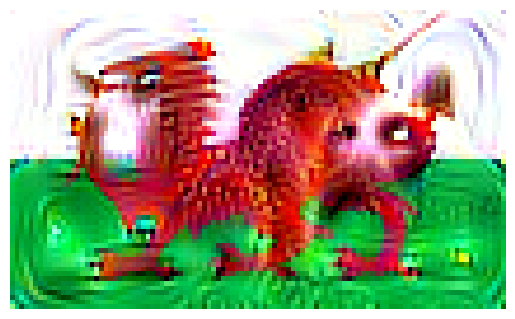

In [30]:
#patch = patch_attack(model, 911)
visualise_patch(patch)